# Antibody non_h3 CDR fitting analysis

## Import

In [1]:
from pathlib import Path
from typing import Union, List
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import json
%matplotlib inline


## Configuration

change the base

In [ ]:
BASE = Path("/Users/lynnricky/scripts/CDR-modelling-evaluation")
config = {
    "input": {
        "abymod": BASE.joinpath("output/run_profit_abpackingangle/abymod_nt"),
        "rosetta": BASE.joinpath("output/run_profit_abpackingangle/rosetta_nt"),
        "IgFold": BASE.joinpath("output/run_profit_abpackingangle/IgFold"),
    },
    "output": {
        "figures": BASE.joinpath("analysis/CDR/non_H3_figure/density"),
        "box": BASE.joinpath("analysis/CDR/non_H3_figure/density")
    }
}

## Function

In [3]:
# extract RMSD, fitting region, fitting type from json file
def load_json_as_df(input_dir: Path, method_type: str = None):
    result = []  # "abdbid", "cdr", "rmsd", "fitting"
    json_fps = input_dir.glob(f"*.json")
    for json_fp in json_fps:
        with open(json_fp, "r") as f:
            data = json.load(f)
            abdbid = data["abdb_id"]
            for a, b, c in zip(data["cdr"], data["rmsd"], data["fitting"]):
                result.append([abdbid, a, b, c])
    df = pd.DataFrame(result)
    df.columns = ["abdbid", "cdr", "rmsd", "fitting"]
    if method_type:
        df["method"] = [method_type] * df.shape[0]
    return df

## Main

In [4]:
df = pd.concat([load_json_as_df(config["input"]["abymod"], method_type="abYmod"),
                load_json_as_df(config["input"]["lyra"], method_type="lyra"),
                load_json_as_df(config["input"]["IgFold"], method_type="IgFold"),
               load_json_as_df(config["input"]["rosetta"], method_type="Rosetta")], axis=0)
df.reset_index(drop=True, inplace=True )

In [5]:
df.head(12)

,abdbid,cdr,rmsd,fitting,method
0,3o6k_0,H1,0.665,local,abYmod
1,3o6k_0,H2,0.272,local,abYmod
2,3o6k_0,H3,1.485,local,abYmod
3,3o6k_0,L1,0.243,local,abYmod
4,3o6k_0,L2,0.271,local,abYmod
5,3o6k_0,L3,0.497,local,abYmod
6,3o6k_0,HFR,0.588,global,abYmod
7,3o6k_0,H1,0.804,global,abYmod
8,3o6k_0,H2,0.985,global,abYmod
9,3o6k_0,H3,1.806,global,abYmod


In [5]:
result = df[df['method'] == 'Rosetta']['abdbid'].unique().tolist()
df = df[df['abdbid'].isin(result)]

examine null value

In [6]:
df[pd.isnull(df).any(axis=1)]

,abdbid,cdr,rmsd,fitting,method


In [58]:
df.head()

,abdbid,cdr,rmsd,fitting,method
0,3o6k_0,H1,0.665,local,abYmod
1,3o6k_0,H2,0.272,local,abYmod
2,3o6k_0,H3,1.485,local,abYmod
3,3o6k_0,L1,0.243,local,abYmod
4,3o6k_0,L2,0.271,local,abYmod


## Plot

In [10]:
# plot
def plot_fitting( data: pd.DataFrame,
                 fitting_type: str, rmsd_cutoff: float = None,
                 save_fig: bool = False, out_dir: Path = None,
                 transparent: bool = True):
    assert fitting_type in ("global", "local")
    if not rmsd_cutoff:
        rmsd_cutoff = 8.0
    cdrs = ("L1", "L2", "L3", "H1", "H2", "H3")
    fig, axes = plt.subplots(2, 3, figsize=(15, 6), sharex="all", sharey="all")
    for i, cdr in enumerate(cdrs):
        ax = axes[i//3][i%3]
        data_df = df[(df.cdr==cdr) & (df.rmsd < rmsd_cutoff) & (df.fitting==fitting_type)][["rmsd", "method"]]
        sns.kdeplot(data=data_df, x="rmsd", hue="method", ax=ax, common_norm=False)
        # beautify
        ax.set_xlim(0, rmsd_cutoff)
        # show tick and tick labels even with sharex=True
        ax.tick_params(axis="x", bottom=True, labelbottom=True)
        ax.tick_params(axis="y", left=True, labelleft=True)
        # title
        sample_size = data_df.groupby("method").count().iloc[:, 0].to_dict()
        abymod_size = sample_size["abYmod"]
        igfold_size = sample_size["IgFold"]
        lyra_size = sample_size["lyra"]
        rosetta_size = sample_size["Rosetta"]
        ax.set_title(f"{cdr}, size - abYmod: {abymod_size}, IgFold: {igfold_size}, lyra: {lyra_size}, Rosetta:{rosetta_size}")
        # grid
        ax.grid(alpha=0.3)
    fig_title = f"{fitting_type[0].upper()+fitting_type[1:]} fitting " + \
                r"($\mathrm{C_\alpha RMSD\ <}$" + \
                f"{rmsd_cutoff }" + \
                r"$\mathrm{\AA})$"
    fig.suptitle(fig_title, fontsize=14)
    fig.tight_layout()
    plt.show()

    if save_fig:
        if not out_dir:
            out_dir = Path(".")
        fn = f"{fitting_type}-rmsd_thr{rmsd_cutoff:.0f}"
        fig.savefig(out_dir.joinpath(f"{fn}.png"), dpi=300, transparent=transparent)
        fig.savefig(out_dir.joinpath(f"{fn}.pdf"), transparent=transparent)

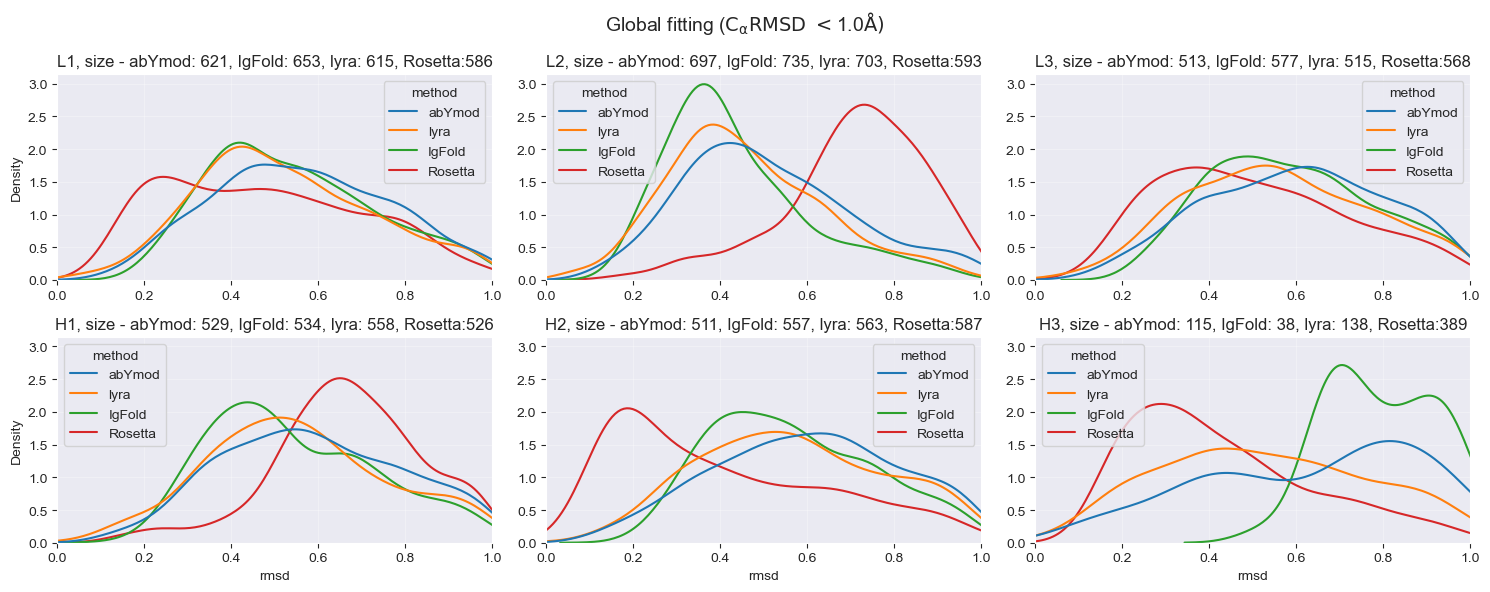

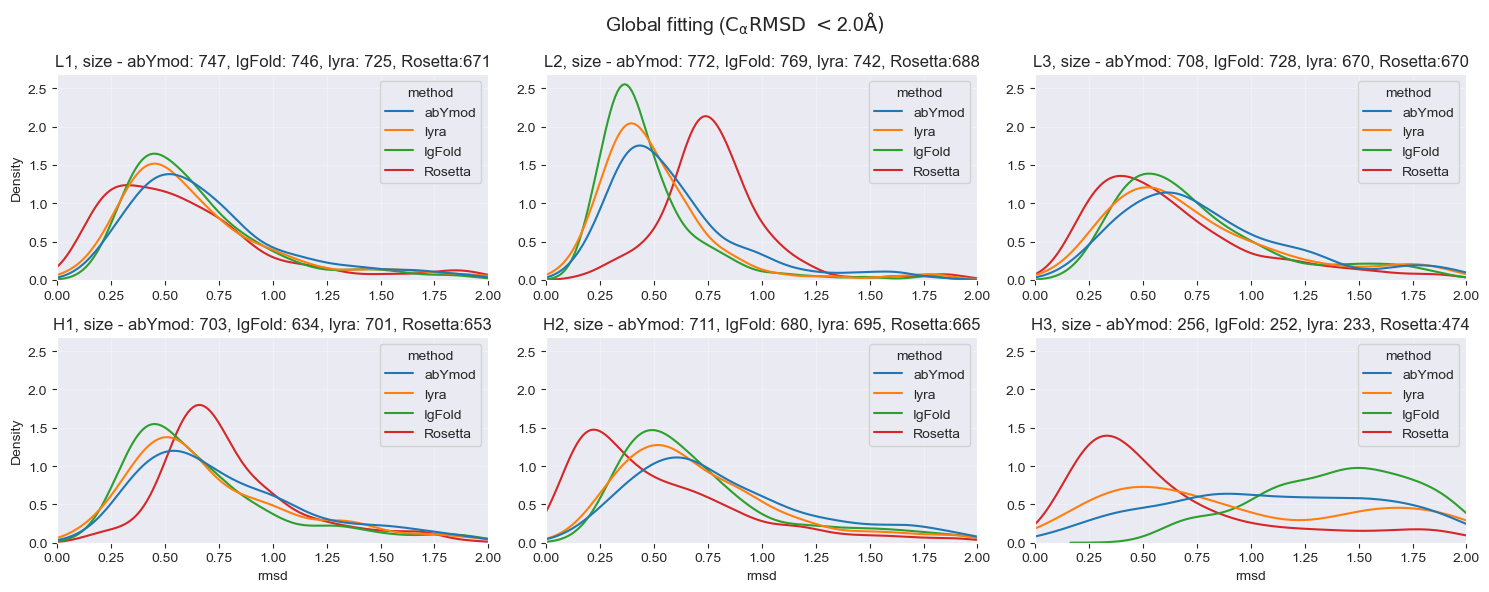

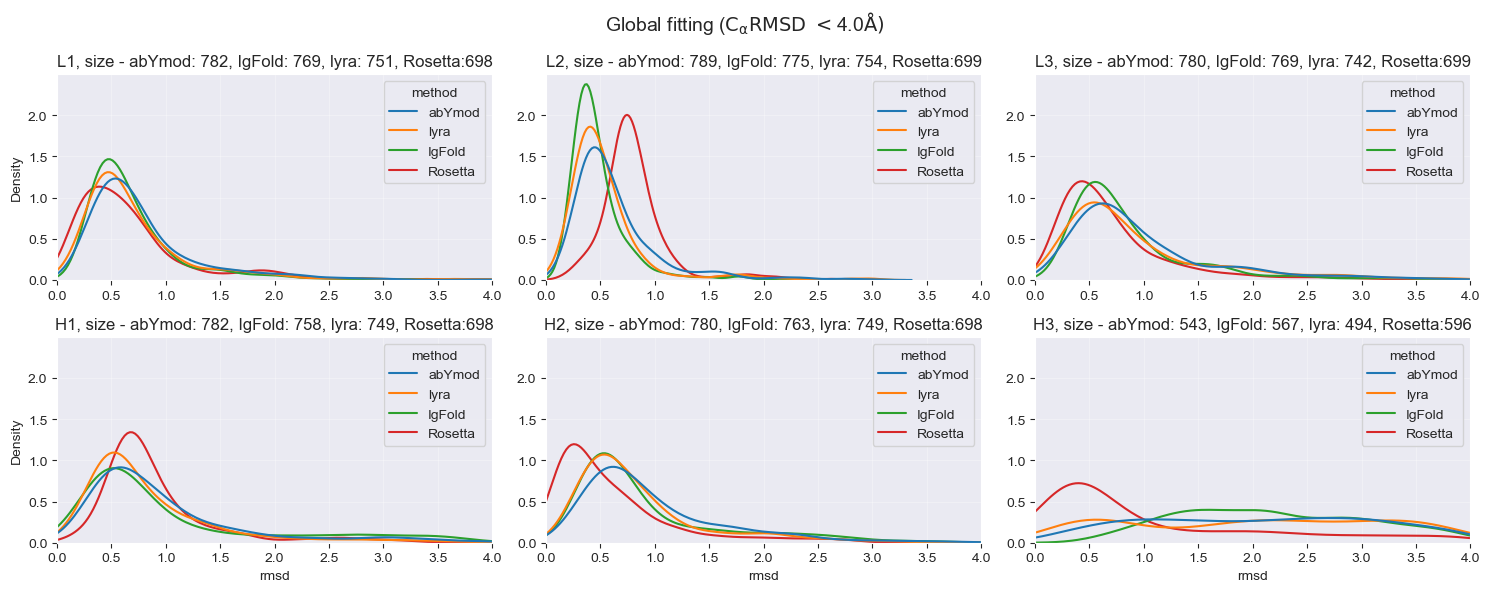

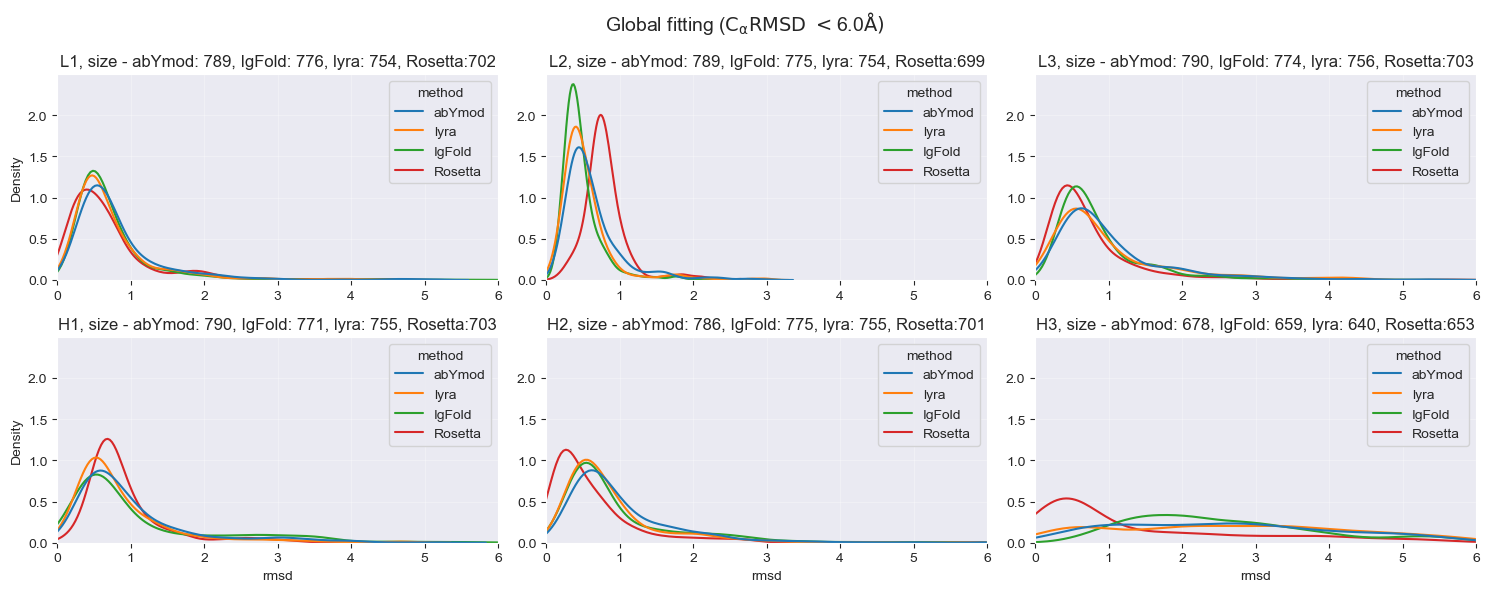

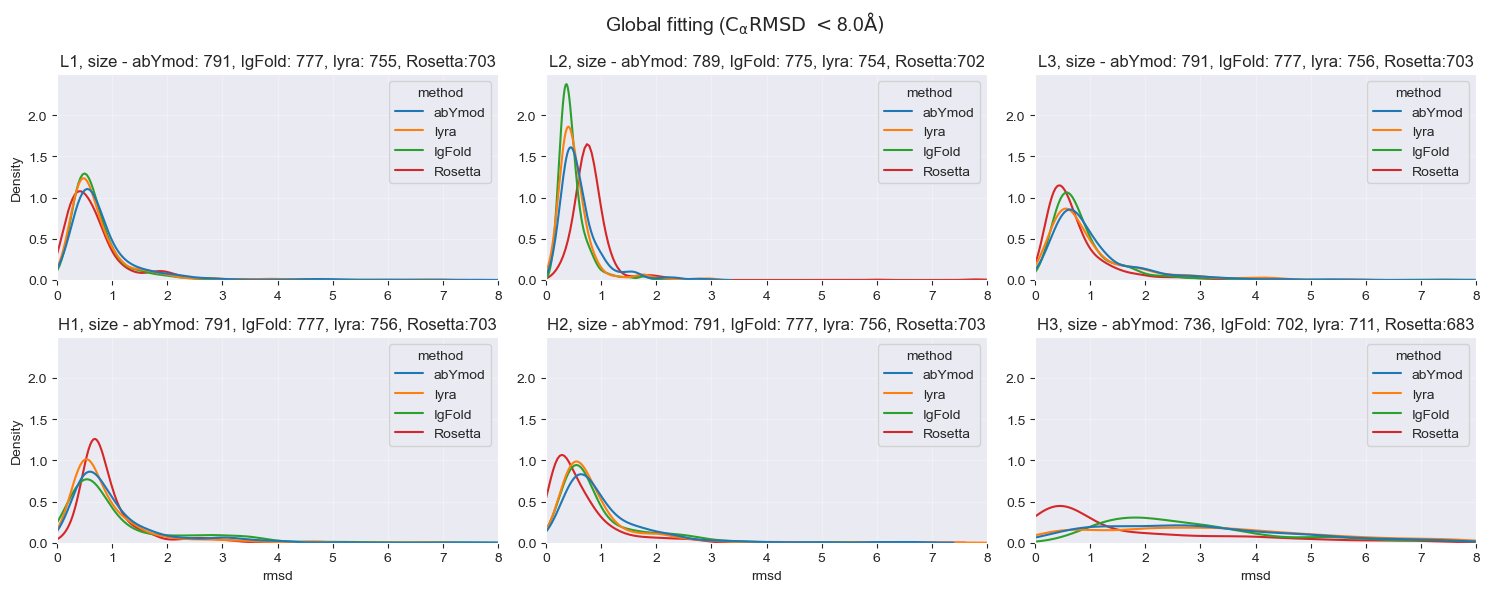

In [11]:
# global fitting, rmsd cutoff = 1.0
plot_fitting(data=df, fitting_type="global", rmsd_cutoff=1.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)
# global fitting, rmsd cutoff = 2.0
plot_fitting(data=df, fitting_type="global", rmsd_cutoff=2.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)
# global fitting, rmsd cutoff = 4.0
plot_fitting(data=df, fitting_type="global", rmsd_cutoff=4.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)
# global fitting, rmsd cutoff = 8.0
plot_fitting(data=df, fitting_type="global", rmsd_cutoff=6.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)
plot_fitting(data=df, fitting_type="global", rmsd_cutoff=8.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)

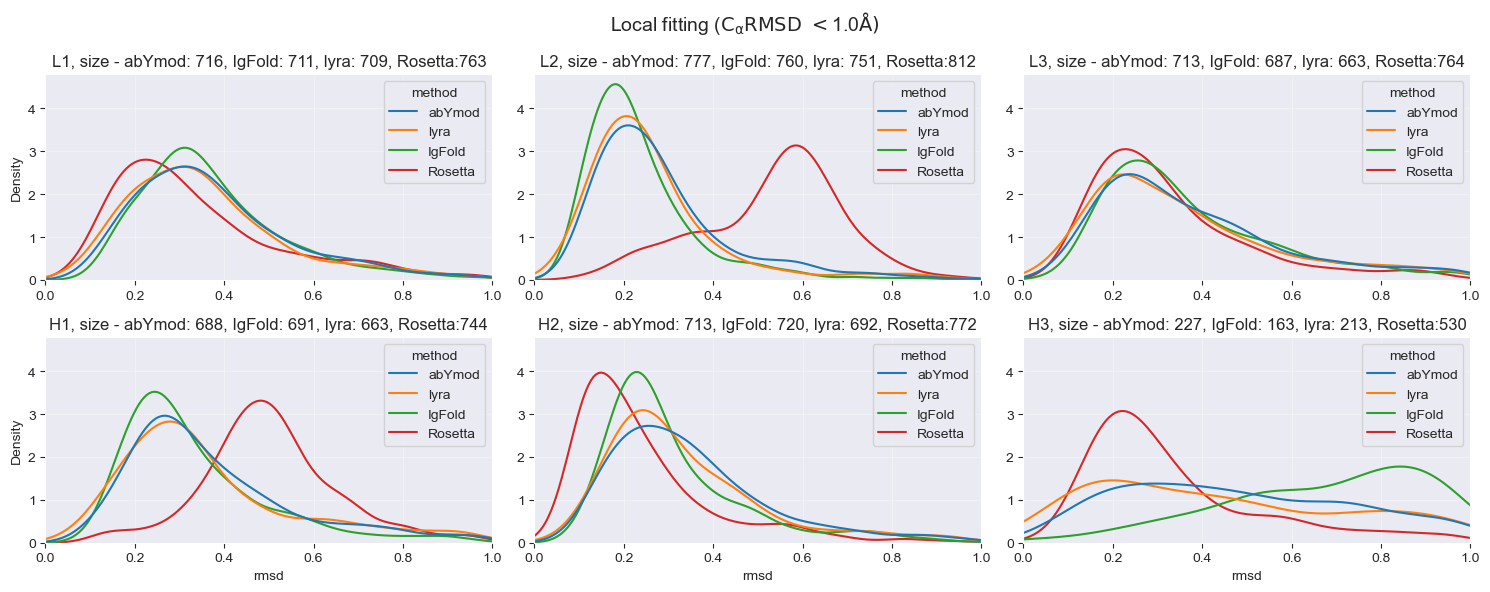

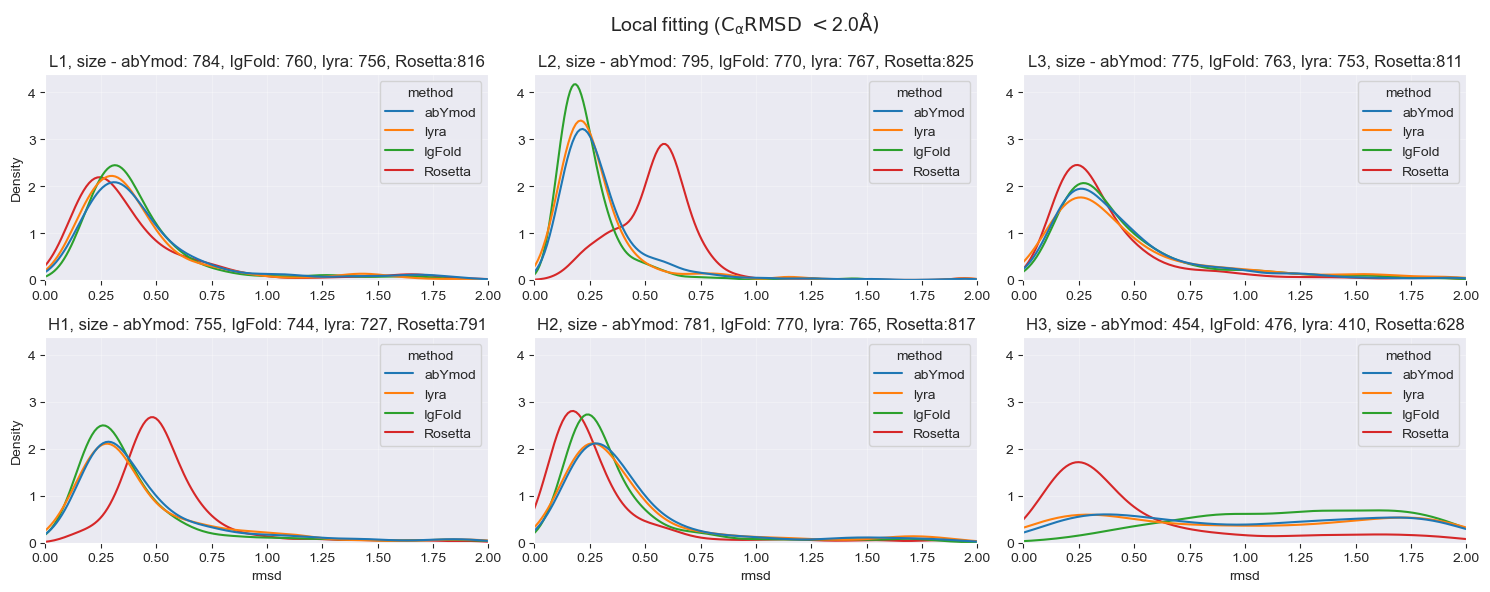

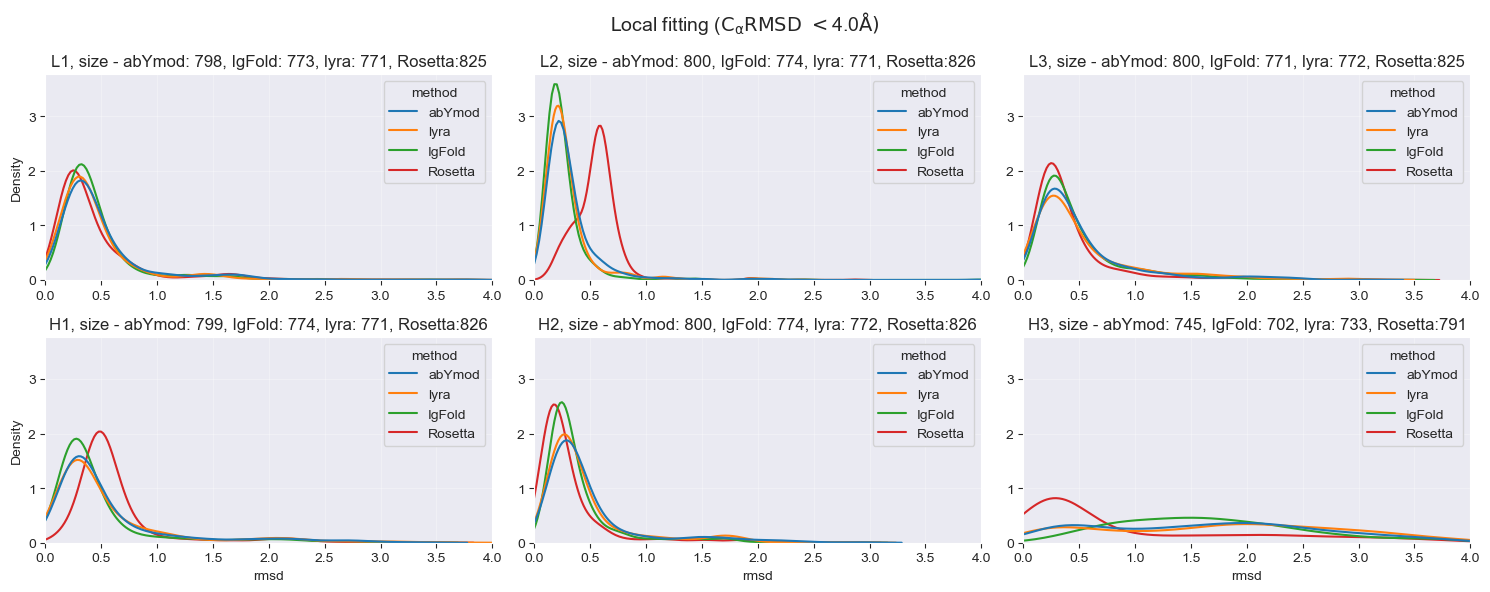

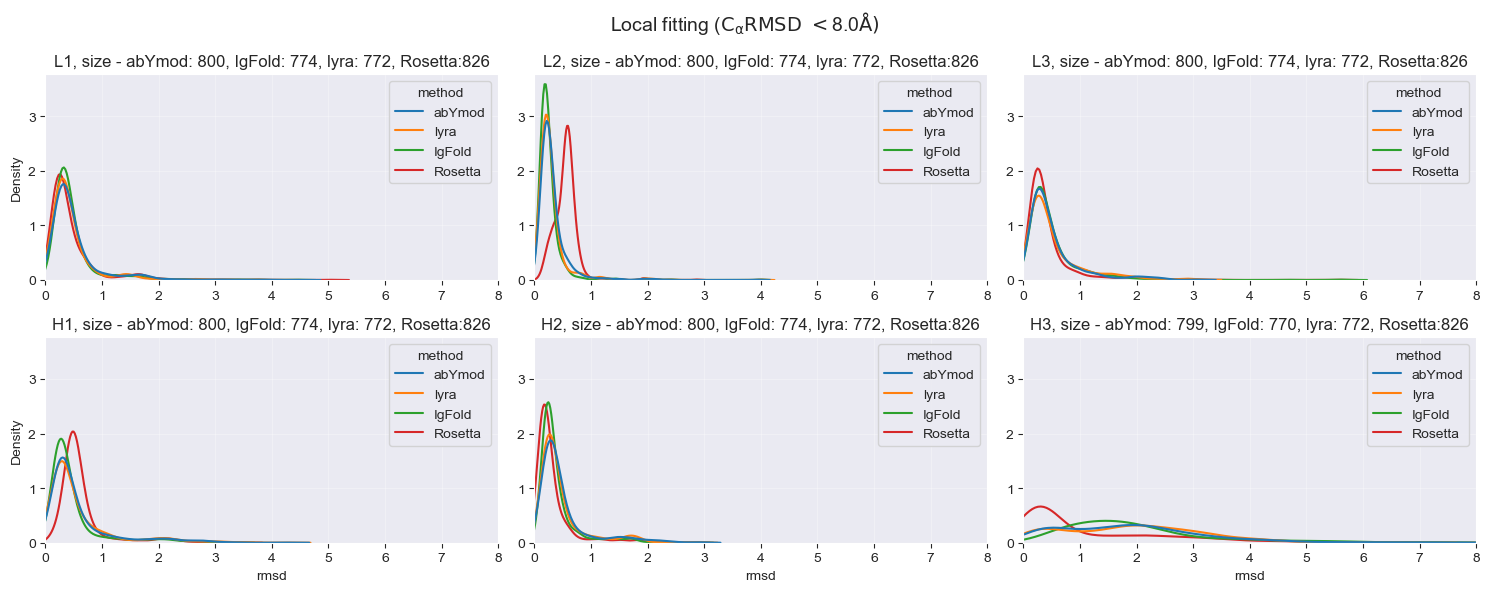

In [12]:
# local fitting, rmsd cutoff = 1.0
plot_fitting(data=df, fitting_type="local", rmsd_cutoff=1.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)
# local fitting, rmsd cutoff = 2.0
plot_fitting(data=df, fitting_type="local", rmsd_cutoff=2.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)
# local fitting, rmsd cutoff = 4.0
plot_fitting(data=df, fitting_type="local", rmsd_cutoff=4.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)
# local fitting, rmsd cutoff = 8.0
plot_fitting(data=df, fitting_type="local", rmsd_cutoff=8.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)

plot box plot for local/global fitting & their difference with/without outliers

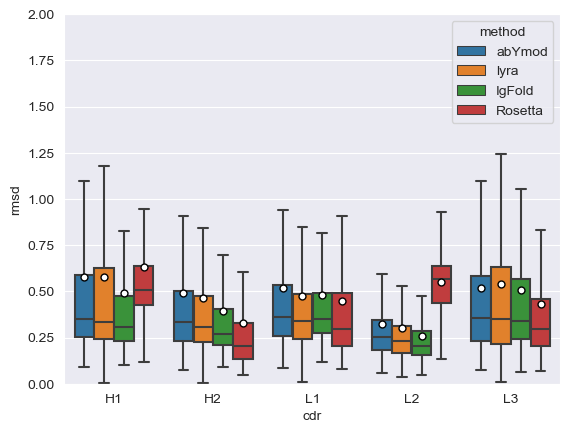

In [13]:
cdr=["H1","H2","L1","L2","L3"]
df_cdr = df[df['cdr'].isin(cdr)]
df_local=df_cdr[df_cdr['fitting']=="local"]

compare=sns.boxplot(x="cdr", y="rmsd",
            hue="method",
            data=df_local, showfliers = False,showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white",
                       "markeredgecolor":"black",
                      "markersize":"5"})
compare.set_ylim(0, 2)
plt.savefig(config["output"]["box"].joinpath(f"local.pdf"))

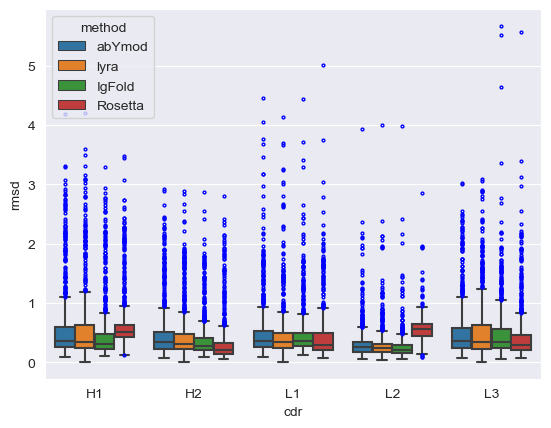

In [18]:
df_local=df_cdr[df_cdr['fitting']=="local"]
flierprops = dict(marker='o', markerfacecolor='None', markersize=2,  markeredgecolor='blue')
compare=sns.boxplot(x="cdr", y="rmsd",
            hue="method",
            data=df_local, showfliers = True, flierprops=flierprops)
plt.savefig(config["output"]["box"].joinpath(f"local_outlier.pdf"))

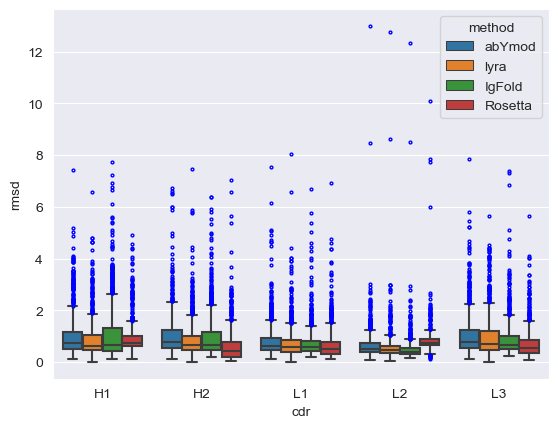

In [16]:
df_global=df_cdr[df_cdr['fitting']=="global"]
flierprops = dict(marker='o', markerfacecolor='None', markersize=2,  markeredgecolor='blue')
compare=sns.boxplot(x="cdr", y="rmsd",
            hue="method",
            data=df_global, showfliers = True, flierprops=flierprops)

plt.savefig(config["output"]["box"].joinpath(f"global_outlier.pdf"))

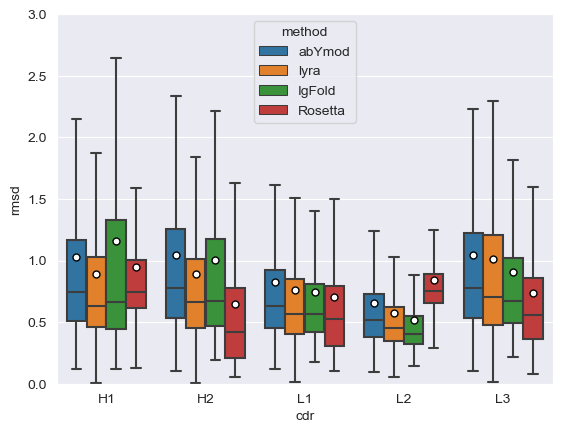

In [19]:
cdr=["H1","H2","L1","L2","L3"]
df_cdr = df[df['cdr'].isin(cdr)]
df_global=df_cdr[df_cdr['fitting']=="global"]

compare=sns.boxplot(x="cdr", y="rmsd",
            hue="method",
            data=df_global, showfliers = False,showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white",
                       "markeredgecolor":"black",
                      "markersize":"5"})
compare.set_ylim(0, 3)
plt.savefig(config["output"]["box"].joinpath(f"global.pdf"))

In [21]:
cdr=["H1","H2","L1","L2","L3"]
df_cdr = df[df['cdr'].isin(cdr)]

In [22]:
df_cdr = df[df['cdr'].isin(cdr)]
df_global=df_cdr[df_cdr['fitting']=="global"]
df_global.rename(columns={'rmsd':'rmsd_g'}, inplace=True)
df_local=df_cdr[df_cdr['fitting']=="local"]

/var/folders/kb/v5p986410234pxvmf90z4vpm0000gn/T/ipykernel_20682/1262371865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_global.rename(columns={'rmsd':'rmsd_g'}, inplace=True)


In [24]:
df_diff=df_local.merge(df_global, on=["abdbid", "cdr", "method"])

In [25]:
df_diff["diff"]= df_diff["rmsd_g"]-df_diff["rmsd"]

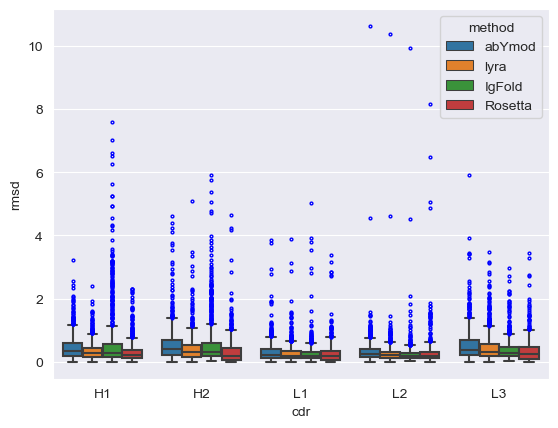

In [27]:
flierprops = dict(marker='o', markerfacecolor='None', markersize=2,  markeredgecolor='blue')
compare=sns.boxplot(x="cdr", y="diff",
            hue="method",
            data=df_diff, showfliers = True, flierprops=flierprops)
compare.set_ylabel("rmsd")
plt.savefig(config["output"]["box"].joinpath(f"diff_outlier.pdf"))

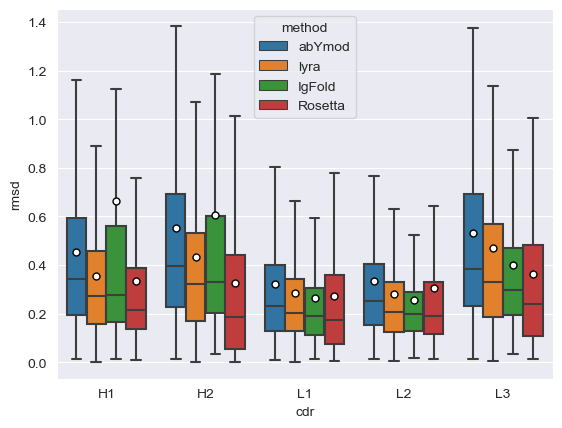

In [28]:
compare=sns.boxplot(x="cdr", y="diff",
            hue="method",
            data=df_diff, showfliers = False,showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white",
                       "markeredgecolor":"black",
                      "markersize":"5"})
compare.set_ylabel("rmsd")
plt.savefig(config["output"]["box"].joinpath(f"diff.pdf"))

local mean value

In [29]:
 df_local=df[df['fitting']=="local"]
dict1_local={ "abymod": [(df_local.loc[(df_local['cdr'] == 'H1') & (df_local['method'] == 'abYmod'), 'rmsd'].mean()), (df_local.loc[(df_local['cdr'] == 'H2') & (df_local['method'] == 'abYmod'), 'rmsd'].mean()), (df_local.loc[(df_local['cdr'] == 'H3') & (df_local['method'] == 'abYmod'), 'rmsd'].mean()), (df_local.loc[(df_local['cdr'] == 'L1') & (df_local['method'] == 'abYmod'), 'rmsd'].mean()), (df_local.loc[(df_local['cdr'] == 'L2') & (df_local['method'] == 'abYmod'), 'rmsd'].mean()), (df_local.loc[(df_local['cdr'] == 'L3') & (df_local['method'] == 'abYmod'), 'rmsd'].mean())],

"Igfold": [(df_local.loc[(df_local['cdr'] == 'H1') & (df_local['method'] == 'IgFold'), 'rmsd'].mean()), (df_local.loc[(df_local['cdr'] == 'H2') & (df_local['method'] == 'IgFold'), 'rmsd'].mean()), (df_local.loc[(df_local['cdr'] == 'H3') & (df_local['method'] == 'IgFold'), 'rmsd'].mean()), (df_local.loc[(df_local['cdr'] == 'L1') & (df_local['method'] == 'IgFold'), 'rmsd'].mean()), (df_local.loc[(df_local['cdr'] == 'L2') & (df_local['method'] == 'IgFold'), 'rmsd'].mean()), (df_local.loc[(df_local['cdr'] == 'L3') & (df_local['method'] == 'IgFold'), 'rmsd'].mean())],

"lyra": [(df_local.loc[(df_local['cdr'] == 'H1') & (df_local['method'] == 'lyra'), 'rmsd'].mean()), (df_local.loc[(df_local['cdr'] == 'H2') & (df_local['method'] == 'lyra'), 'rmsd'].mean()), (df_local.loc[(df_local['cdr'] == 'H3') & (df_local['method'] == 'lyra'), 'rmsd'].mean()), (df_local.loc[(df_local['cdr'] == 'L1') & (df_local['method'] == 'lyra'), 'rmsd'].mean()), (df_local.loc[(df_local['cdr'] == 'L2') & (df_local['method'] == 'lyra'), 'rmsd'].mean()), (df_local.loc[(df_local['cdr'] == 'L3') & (df_local['method'] == 'lyra'), 'rmsd'].mean())],


"Rosetta": [(df_local.loc[(df_local['cdr'] == 'H1') & (df_local['method'] == 'Rosetta'), 'rmsd'].mean()), (df_local.loc[(df_local['cdr'] == 'H2') & (df_local['method'] == 'Rosetta'), 'rmsd'].mean()), (df_local.loc[(df_local['cdr'] == 'H3') & (df_local['method'] == 'Rosetta'), 'rmsd'].mean()), (df_local.loc[(df_local['cdr'] == 'L1') & (df_local['method'] == 'Rosetta'), 'rmsd'].mean()), (df_local.loc[(df_local['cdr'] == 'L2') & (df_local['method'] == 'Rosetta'), 'rmsd'].mean()), (df_local.loc[(df_local['cdr'] == 'L3') & (df_local['method'] == 'Rosetta'), 'rmsd'].mean())] }

In [30]:
H1_local=pd.DataFrame.from_dict(dict1_local)
H1_local.index= ["H1","H2","H3", "L1","L2","L3"]
H1_local

,abymod,Igfold,lyra,Rosetta
H1,0.576704,0.489111,0.575272,0.632144
H2,0.489208,0.392508,0.464534,0.328990
H3,1.895241,2.029098,1.916237,1.154286
L1,0.517375,0.478239,0.475100,0.446771
L2,0.322101,0.260814,0.299013,0.549525
L3,0.516303,0.508783,0.539861,0.430245


global mean value

In [31]:
df_global=df[df['fitting']=="global"]
dict1_global={
    "abymod": [(df_global.loc[(df_global['cdr'] == 'H1') & (df_global['method'] == 'abYmod'), 'rmsd'].mean()), (df_global.loc[(df_global['cdr'] == 'H2') & (df_global['method'] == 'abYmod'), 'rmsd'].mean()), (df_global.loc[(df_global['cdr'] == 'H3') & (df_global['method'] == 'abYmod'), 'rmsd'].mean()), (df_global.loc[(df_global['cdr'] == 'L1') & (df_global['method'] == 'abYmod'), 'rmsd'].mean()), (df_global.loc[(df_global['cdr'] == 'L2') & (df_global['method'] == 'abYmod'), 'rmsd'].mean()), (df_global.loc[(df_global['cdr'] == 'L3') & (df_global['method'] == 'abYmod'), 'rmsd'].mean())],

"Igfold": [(df_global.loc[(df_global['cdr'] == 'H1') & (df_global['method'] == 'IgFold'), 'rmsd'].mean()), (df_global.loc[(df_global['cdr'] == 'H2') & (df_global['method'] == 'IgFold'), 'rmsd'].mean()), (df_global.loc[(df_global['cdr'] == 'H3') & (df_global['method'] == 'IgFold'), 'rmsd'].mean()), (df_global.loc[(df_global['cdr'] == 'L1') & (df_global['method'] == 'IgFold'), 'rmsd'].mean()), (df_global.loc[(df_global['cdr'] == 'L2') & (df_global['method'] == 'IgFold'), 'rmsd'].mean()), (df_global.loc[(df_global['cdr'] == 'L3') & (df_global['method'] == 'IgFold'), 'rmsd'].mean())],

"lyra": [(df_global.loc[(df_global['cdr'] == 'H1') & (df_global['method'] == 'lyra'), 'rmsd'].mean()), (df_global.loc[(df_global['cdr'] == 'H2') & (df_global['method'] == 'lyra'), 'rmsd'].mean()), (df_global.loc[(df_global['cdr'] == 'H3') & (df_global['method'] == 'lyra'), 'rmsd'].mean()), (df_global.loc[(df_global['cdr'] == 'L1') & (df_global['method'] == 'lyra'), 'rmsd'].mean()), (df_global.loc[(df_global['cdr'] == 'L2') & (df_global['method'] == 'lyra'), 'rmsd'].mean()), (df_global.loc[(df_global['cdr'] == 'L3') & (df_global['method'] == 'lyra'), 'rmsd'].mean())],

"Rosetta": [(df_global.loc[(df_global['cdr'] == 'H1') & (df_global['method'] == 'Rosetta'), 'rmsd'].mean()), (df_global.loc[(df_global['cdr'] == 'H2') & (df_global['method'] == 'Rosetta'), 'rmsd'].mean()), (df_global.loc[(df_global['cdr'] == 'H3') & (df_global['method'] == 'Rosetta'), 'rmsd'].mean()), (df_global.loc[(df_global['cdr'] == 'L1') & (df_global['method'] == 'Rosetta'), 'rmsd'].mean()), (df_global.loc[(df_global['cdr'] == 'L2') & (df_global['method'] == 'Rosetta'), 'rmsd'].mean()), (df_global.loc[(df_global['cdr'] == 'L3') & (df_global['method'] == 'Rosetta'), 'rmsd'].mean())] }

In [36]:
H1_global=pd.DataFrame.from_dict(dict1_global)
H1_global.index= ["H1","H2","H3","L1","L2","L3"]
H1_global

,abymod,Igfold,lyra,Rosetta
H1,1.030669,1.154529,0.887284,0.944930
H2,1.042580,1.000631,0.888746,0.649428
H3,3.471587,3.573377,3.504750,1.934592
L1,0.829713,0.746375,0.758733,0.705408
L2,0.656024,0.516319,0.570893,0.845549
L3,1.042728,0.905121,1.010442,0.738727


diff mean value

In [37]:
diff=H1_global.subtract(H1_local)

In [39]:
diff

,abymod,Igfold,lyra,Rosetta
H1,0.453965,0.665418,0.312012,0.312786
H2,0.553373,0.608123,0.424212,0.320438
H3,1.576345,1.544279,1.588513,0.780306
L1,0.312338,0.268135,0.283633,0.258637
L2,0.333923,0.255505,0.271880,0.296024
L3,0.526426,0.396338,0.470580,0.308482
